In [5]:
import numpy as np

In [6]:
import cv2
import matplotlib.pyplot as plt

In [7]:
def to_affine(p):
    if len(p) == 2:
        return np.array([float(x) for x in p])
    if p[2] == 0:
        return None
    return np.array([1.0*p[0]/p[2], 1.0*p[1]/p[2]])



In [8]:
def to_projective(p):
    if len(p) == 3:
        return np.array([float(x) for x in p])
    return np.array([1.0*p[0], 1.0*p[1], 1.0])


In [9]:
def naiive(originals, images, round=5):

    [A, B, C, D] = list(map(to_projective, originals))
    [Ap, Bp, Cp, Dp] = list(map(to_projective, images))

    [alfa, beta, gamma] = list(
                          np.matmul(np.linalg.inv(np.array([A, B, C]).T), np.array([D]).T)
                            )
  
    [alfap, betap, gammap] = list(
                          np.matmul(np.linalg.inv(np.array([Ap, Bp, Cp]).T), np.array([Dp]).T)
                               )

    P1 = np.array([alfa*A, beta*B, gamma*C]).T
    P2 = np.array([alfap*Ap, betap*Bp, gammap*Cp]).T

    P = np.matmul(P2, np.linalg.inv(P1))
    if round == 'no':
        return P
    return np.round(P, decimals=round)
  

In [10]:
def DLT(originals, images, round=5):
    
    originals = map(to_projective, originals)
    images = map(to_projective, images)
    A = np.empty(shape=(0, 9))
    for Mi, Mip in zip(originals, images):
        row1 = np.array([0, 0, 0])
        row1 = np.hstack((row1, -Mi*np.array([Mip[2]*3])))
        row1 = np.hstack((row1, +Mi*np.array([Mip[1]*3])))

        row2 = np.array(+Mi*np.array([Mip[2]*3]))
        row2 = np.hstack((row2, +np.array([0, 0, 0])))
        row2 = np.hstack((row2, -Mi*np.array([Mip[0]*3])))
#         row1 = np.array([0, 0, 0, -Mip[2]*Mi[0], -Mip[2]*Mi[1], -Mip[2]*Mi[2], Mip[1]*Mi[0], Mip[1]*Mi[1], Mip[1]*Mi[2]])
#         row2 = np.array([Mip[2]*Mi[0], Mip[2]*Mi[1], Mip[2]*Mi[2], 0, 0, 0, -Mip[0]*Mi[0], -Mip[0]*Mi[1], -Mip[0]*Mi[2]])
        A = np.vstack((A, row1))
        A = np.vstack((A, row2))
    
    _, _, v = np.linalg.svd(A, full_matrices=True)
    v = v.T[:, -1].reshape((3, 3))
    if round == 'no':
        return v
    return np.round(v, decimals=round)

  

In [11]:
def affine_centroid_and_dist(pts):
    pts = list(map(to_affine, pts))
    ac = np.sum(pts, axis=0)/len(pts)
    cendist = lambda p: np.sqrt((p[0] - ac[0])**2 + (p[1] - ac[1])**2)
    avgdist = np.average(list(map(cendist, pts)))
    return ac, avgdist

def get_scale_matrix(coeff):
    return np.array([[coeff, 0, 0],
                   [0, coeff, 0],
                   [0, 0, 1]])

def get_translation_matrix(vec):
    return np.array([[1, 0, vec[0]],
                   [0, 1, vec[1]],
                   [0, 0, 1]])

def get_normalization_marix(pts):
    ac, avdist = affine_centroid_and_dist(pts)
    s = get_scale_matrix(np.sqrt(2)/avdist)
    g = get_translation_matrix(-ac)
    return np.matmul(s, g)

In [12]:
def DLT_norm(originals, images, round=5):
    T =  get_normalization_marix(originals)
    Tp = get_normalization_marix(images)

    M_normal  = [np.matmul(T, o)  for o in originals]
    Mp_normal = [np.matmul(Tp, i) for i in images]

    Pbar = DLT(M_normal, Mp_normal)

    P = np.matmul(np.matmul(np.linalg.inv(Tp), Pbar), T)
    if round == 'no':
        return P
    return np.round(P, decimals=round)

In [26]:
np.round(-0.397005785, 5)

-0.39701

In [28]:
def plot_rectangle(plt, pts, **kwargs):
    plt.plot([p[0] for p in pts] + [pts[0][0]], 
             [p[1] for p in pts] + [pts[0][1]],
             **kwargs)

def npp(p):
    if len(p) == 2:
        delim = ','
        extra = ''
    else:
        delim = ':'
        extra = ' '
    return "(" + delim.join([str(c) + extra if c < 0 else " " + str(c) + extra for c in p]) + ")"

def problem_string(o, i):
    return "\n".join([f'{npp(a)}\t--->\t{npp(b)}' for a, b in zip(o, i)])

def at(P, a):
    return np.matmul(P, to_projective(a).T)

def demonstration():
    a  =   [-3,-1]
    b  =   [+3,-1]
    c  =   [+1,+1]
    d  =   [-1,+1]
    ap =   [-2,-1]
    bp =   [+2,-1]
    cp =   [+2,+1]
    dp =   [-2,+1]
    originals = [a, b, c, d]
    images = [ap, bp, cp, dp]
    print(f'Trazimo transformaciju koja slika tacke na sledeci nacin:')
    print(problem_string(originals, images), '\n')

    P1 = naiive(originals, images, round='no')
    print(f'Matrica preslikavanja naivnim algoritmom:\nP1=\n{P1}\n')

    P2 = DLT(originals, images, round='no')
    print(f'Matrica preslikavanja DLT algoritmom:\nP2=\n{P2}\n')

    P2scaled = (P1[0][0] / P2[0][0])*P2
    print(f'Skalirana DLT matrica, zaokruzena na 5 decimala:\nP2s=\n{np.round(P2scaled, 5)}\n')
    print(f'Zakljucujemo da se radi o istom preslikavanju.')

    print('=====================================================')

    e = [1, 2, 3]
    f = [-8, -2, 1]
    ep = at(P1, e)
    fp = at(P1, f)
    originals = list(map(to_projective, originals + [e, f]))
    images = list(map(to_projective, images + [ep, fp]))
    print(f'Dodajemo jos dve tacke, sada trazimo preslikavanje (projektivne koordinate):')
    print(problem_string(originals, images), '\n')

    P3 = DLT(originals, images, round='no')
    print(f'Matrica preslikavanja 6 tacaka DLT algoritmom:\nP3=\n{P3}\n')
    P3scaled = np.round((P1[0][0]/P3[0][0]) * P3, 5)

    print(f'Skalirana matrica zaokruzena na 5 decimala:\nP3s=\n{P3scaled}\n')
    print(f'Ponovo dobijamo isto preslikavanje.')
    print('=====================================================')

    P4 = DLT_norm(originals, images)
    print(f'Matrica preslikavanja 6 tacaka DLT algoritmom sa normalizacijom:\nP4=\n{P4}\n')
    P4s = np.round((P1[0][0]/P4[0][0])*P4, 5)
    print(f'Skalirana matrica zaokruzena na 5 decimala:\nP4s=\n{P4s}\n')
    print(f'U ovom slucaju ne dobijamo isto preslikavanje vec priblizno.')
    
    print('=====================================================')
    print(f'Pokazujemo invarijantnost modifikovanog DLT algoritma u odnosu na promenu koordinatnog sistema.')
    ### CBM - Change of Basis Matrix
    # rotacija oko koordinatnog pocetka za 90 stepeni
    CBM = np.array([[np.cos(1.5708), -np.sin(1.5708), 0],
                    [np.sin(1.5708), np.cos(1.5708), 0],
                    [0, 0, 1]])
    
    
    originals_newb = [at(CBM, x) for x in originals]
    images_newb =    [at(CBM, x) for x in images]
    print(f'Izvrsili smo rotaciju za 90 stepeni oko koordinatnog pocetka matricom \nC=\n{CBM}\n')
    print(f'Sada trazimo preslikavanje:\n{problem_string(originals_newb, images_newb)}\n')
    
    P5 = DLT_norm(originals_newb, images_newb, round='no')
    print(f'Matrica transformacije:\nP5=\n{P5}\n')
    print(f'Racunamo C^-1 * T * C')
    P5s = np.matmul(np.matmul(np.linalg.inv(CBM), P5), CBM)
    print(f'P5s=\n{P5s}\n')
    print(f'Sada skaliramo i zaokruzimo na 5 decimala: ')
    print(f'coef={P5[0][0]/P5s[0][0]}')
    P5sr = (P5[0][0]/P5s[0][0]) * P5s
    print(np.round(P5sr, 5))
    
    
  




  
demonstration()

Trazimo transformaciju koja slika tacke na sledeci nacin:
(-3,-1)	--->	(-2,-1)
( 3,-1)	--->	( 2,-1)
( 1, 1)	--->	( 2, 1)
(-1, 1)	--->	(-2, 1) 

Matrica preslikavanja naivnim algoritmom:
P1=
[[ 2.  0.  0.]
 [ 0.  2. -1.]
 [ 0. -1.  2.]]

Matrica preslikavanja DLT algoritmom:
P2=
[[ 5.34522484e-01 -5.25651793e-16  7.68809464e-16]
 [-1.11022302e-16  5.34522484e-01 -2.67261242e-01]
 [ 1.11022302e-16 -2.67261242e-01  5.34522484e-01]]

Skalirana DLT matrica, zaokruzena na 5 decimala:
P2s=
[[ 2. -0.  0.]
 [-0.  2. -1.]
 [ 0. -1.  2.]]

Zakljucujemo da se radi o istom preslikavanju.
Dodajemo jos dve tacke, sada trazimo preslikavanje (projektivne koordinate):
(-3.0 :-1.0 : 1.0 )	--->	(-2.0 :-1.0 : 1.0 )
( 3.0 :-1.0 : 1.0 )	--->	( 2.0 :-1.0 : 1.0 )
( 1.0 : 1.0 : 1.0 )	--->	( 2.0 : 1.0 : 1.0 )
(-1.0 : 1.0 : 1.0 )	--->	(-2.0 : 1.0 : 1.0 )
( 1.0 : 2.0 : 3.0 )	--->	( 2.0 : 1.0 : 4.0 )
(-8.0 :-2.0 : 1.0 )	--->	(-16.0 :-5.0 : 4.0 ) 

Matrica preslikavanja 6 tacaka DLT algoritmom:
P3=
[[-5.34522484e-01

In [14]:
def get_points_from_user(title=''):
    print(title)
    print('Format: broj, broj')
    pts = []
    for i in range(4):
        inp = input(f'Tacka {i+1}:')
        if ',' not in inp:
            return None
        x, y = inp.split(',')
        x = x.strip()
        y = y.strip()
        try:
            x = float(x)
            y = float(y)
        except:
            return None
        
        pts.append([x, y])
    return pts
            

--- Otklanjanje projektivne distorzije slike ---


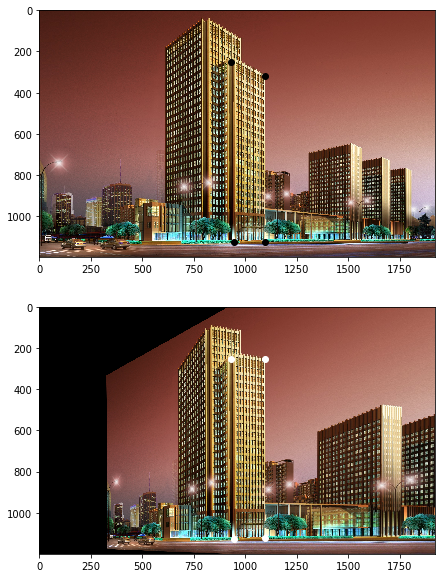

In [15]:
def im_transform(picurl='slika.bmp', default_points=False):
    print('--- Otklanjanje projektivne distorzije slike ---')
    pic = cv2.imread(picurl)
    if default_points:
        orig1 = [943, 1127]
        orig2 = [929, 253]
        orig3 = [1095, 319]
        orig4 = [1095, 1123]
        image1 = [943, 1127]
        image2 = [929, 253]
        image3 = [1095, 253]
        image4 = [1095, 1123]
        originals = [orig1, orig2, orig3, orig4]
        images = [image1, image2, image3, image4]
    else:
        originals = get_points_from_user(title='Unesite 4 tacke (originali): ')
        if originals is None:
            print('Unesite korektne tacke')
            return
        images = get_points_from_user(title='Unesite 4 tacke (slike): ')
        if images is None:
            print('Unesite korektne tacke')
            return
        
    originals = list(map(np.array, originals))
    images = list(map(np.array, images))
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    axs[0].imshow(pic)
    axs[0].scatter([o[0] for o in originals], [o[1] for o in originals], color='black')
    
    Tdlt = DLT(originals, images, round='no')  
    newimg = cv2.warpPerspective(pic, Tdlt, (pic.shape[1], pic.shape[0]))
    
    axs[1].imshow(newimg)
    axs[1].scatter([i[0] for i in images], [i[1] for i in images], color='white')
    plt.show()
    
im_transform(default_points=True)

[]